#### Step 1: Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load datasets
matched_data = pd.read_csv('C:/Users/AM/OneDrive/Desktop/capstone/data/cleaned/matched_data.csv')
usa_spending = pd.read_csv('C:/Users/AM/OneDrive/Desktop/capstone/data/cleaned/cleaned_usa_spending_data.csv')
crunchbase = pd.read_csv('C:/Users/AM/OneDrive/Desktop/capstone/data/cleaned/cleaned_crunchbase_data.csv')

In [3]:
# create a set of matched companies for faster lookup
matched_companies = set(matched_data['match_company'].dropna())

In [4]:
# define a function to check if a company or its parent is in the matched set
def is_new_awardee(row):
    return int(row['clean_recipient_name'] in matched_companies or 
               row['clean_recipient_parent_name'] in matched_companies)

In [5]:
# apply the function to create the new binary column
usa_spending['is_new_awardee'] = usa_spending.apply(is_new_awardee, axis=1)

In [6]:
# verify the results
print(f"Number of new awardees: {usa_spending['is_new_awardee'].sum()}")
print(f"Percentage of new awardees: {usa_spending['is_new_awardee'].mean()*100:.2f}%")

Number of new awardees: 204
Percentage of new awardees: 3.86%


Our modest 50 new awardees quadrupled in number after additionally matching parent companies! While 3.86% is still insignificant, it's just a count and things may look different when we compare award amounts. our goal is to either accept or reject the hypothesis that states "*US government increasily invests in new companies*" (simplified). 

Is there indeed a trend? Outlook doesn't look promising.

In [7]:
# check dataframe structures
print("USA Spending columns:")
print(usa_spending.columns)

print("\nMatched Data columns:")
print(matched_data.columns)

USA Spending columns:
Index(['contract_award_unique_key', 'award_id_piid', 'total_obligated_amount',
       'current_total_value_of_award', 'potential_total_value_of_award',
       'award_base_action_date', 'award_base_action_year', 'current_end_date',
       'awarding_agency_name', 'awarding_sub_agency_name',
       'funding_agency_name', 'funding_sub_agency_name', 'recipient_name',
       'recipient_parent_name', 'recipient_city_name', 'recipient_state_code',
       'recipient_zipcode', 'primary_place_of_performance_city_name',
       'primary_place_of_performance_state_code', 'award_type',
       'type_of_contract_pricing', 'product_or_service_code_description',
       'naics_code', 'naics_description', 'number_of_offers_received',
       'organizational_type', 'clean_recipient_name',
       'clean_recipient_parent_name', 'is_new_awardee'],
      dtype='object')

Matched Data columns:
Index(['company_name', 'year_founded', 'industries', 'cb_hq', 'zipcode',
       'description', 'ope

In [8]:
# prepare data for new awardees
new_awardees = usa_spending[usa_spending['is_new_awardee'] == 1].copy()
new_awardees['year'] = pd.to_datetime(new_awardees['award_base_action_date']).dt.year
new_awardees_summary = new_awardees.groupby(['year', 'clean_recipient_name'])['total_obligated_amount'].sum().reset_index()

In [9]:
# prepare data for traditional contractors
traditional_contractors = usa_spending[usa_spending['is_new_awardee'] == 0].copy()
traditional_contractors['year'] = pd.to_datetime(traditional_contractors['award_base_action_date']).dt.year
traditional_contractors_summary = traditional_contractors.groupby(['year', 'clean_recipient_name'])['total_obligated_amount'].sum().reset_index()

For startups, let's first check the data availability:

In [10]:
print("Missing values in 'funding_date':", crunchbase['funding_date'].isna().sum())
print("Missing values in 'year_founded':", crunchbase['year_founded'].isna().sum())

# Check the unique values in funding_date
print("\nUnique values in 'funding_date':")
print(crunchbase['funding_date'].unique())

# Check the unique values in year_founded
print("\nUnique values in 'year_founded':")
print(crunchbase['year_founded'].unique())

# Check the data types of these columns
print("\nData types:")
print(crunchbase[['funding_date', 'year_founded']].dtypes)

Missing values in 'funding_date': 0
Missing values in 'year_founded': 0

Unique values in 'funding_date':
['2020-01-27' '2020-09-22' '2020-09-11' '0' '2019-02-04' '2024-04-03'
 '2017-07-28' '2021-11-10' '2022-06-21' '2020-06-01' '2017-01-01'
 '2020-10-01' '2024-05-21' '2024-07-12' '2021-12-07' '2020-03-02'
 '2018-04-20' '2021-01-01' '2024-05-22' '2020-01-01' '2021-10-26'
 '2021-06-29' '2022-10-20' '2020-03-20' '2023-09-25' '2018-05-23'
 '2020-12-17' '2017-05-30' '2017-02-24' '2016-03-04' '2022-05-11'
 '2023-01-10' '2023-01-31' '2022-01-19' '2018-10-23' '2021-12-08'
 '2018-06-25' '2021-11-08' '2021-03-24' '2022-07-25' '2022-05-24'
 '2023-04-19' '2020-04-28' '2023-11-08' '2020-01-06' '2024-04-23'
 '2018-12-27' '2022-09-14' '2022-11-29' '2024-02-14' '2023-10-05'
 '2020-11-06' '2022-10-11' '2023-12-05' '2023-07-06' '2023-10-18'
 '2023-12-20' '2021-04-26' '2022-11-04' '2020-05-01' '2023-04-11'
 '2019-05-31' '2020-10-19' '2021-09-03' '2024-10-03' '2024-04-05'
 '2024-03-18' '2023-12-12' '2022

In [11]:
# we would check which date field is better for analyzing our data

zero_funding_dates = (crunchbase['funding_date'] == '0').sum()
print(f"Number of '0' values in funding_date: {zero_funding_dates}")

zero_founding_years = (crunchbase['year_founded'] == '0').sum()
print(f"Number of '0' values in year_founded: {zero_founding_years}")

Number of '0' values in funding_date: 481
Number of '0' values in year_founded: 0


In [12]:
# convert funding_date to datetime, coercing errors to NaT
crunchbase['funding_year'] = pd.to_datetime(crunchbase['funding_date'], errors='coerce').dt.year

# use year_founded when funding_date is '0'
crunchbase.loc[crunchbase['funding_date'] == '0', 'funding_year'] = crunchbase['year_founded']

# ensure year_founded is numeric
crunchbase['year_founded'] = pd.to_numeric(crunchbase['year_founded'], errors='coerce')

print("Distribution of funding years:")
print(crunchbase['funding_year'].value_counts().sort_index())

print("\nDistribution of founding years:")
print(crunchbase['year_founded'].value_counts().sort_index())

Distribution of funding years:
funding_year
1917.0      1
2015.0     56
2016.0     75
2017.0     89
2018.0     96
2019.0     73
2020.0     77
2021.0    101
2022.0    146
2023.0    115
2024.0     73
Name: count, dtype: int64

Distribution of founding years:
year_founded
2015    112
2016    128
2017    140
2018    128
2019     97
2020     85
2021    105
2022     65
2023     35
2024      7
Name: count, dtype: int64


In [13]:
# fix the 1917 typo
crunchbase.loc[crunchbase['funding_year'] == 1917, 'funding_year'] = 2017

In [14]:
# convert funding_year to integer
crunchbase['funding_year'] = crunchbase['funding_year'].astype(int)

In [15]:
# filter for the years 2015-2025
startups_filtered = crunchbase[(crunchbase['funding_year'] >= 2015) & (crunchbase['funding_year'] <= 2025)]

# keep company-level data
startups_summary = startups_filtered[['funding_year', 'company_name', 'total_funding']].copy()
startups_summary = startups_summary.rename(columns={'funding_year': 'year', 'total_funding': 'amount'})
startups_summary['category'] = 'Startups'

In [16]:
# combine data
new_awardees_summary['category'] = 'New Awardees'
traditional_contractors_summary['category'] = 'Traditional Contractors'
startups_summary['category'] = 'Startups'

all_funding = pd.concat([
    new_awardees_summary.rename(columns={'total_obligated_amount': 'amount', 'clean_recipient_name': 'company_name'}),
    traditional_contractors_summary.rename(columns={'total_obligated_amount': 'amount', 'clean_recipient_name': 'company_name'}),
    startups_summary
])

print("\nCombined funding data:")
print(all_funding.head())


Combined funding data:
   year                      company_name        amount      category
0  1999                           PERATON  3.035034e+08  New Awardees
1  2005                           PERATON  5.493580e+06  New Awardees
2  2009                          RAYTHEON  1.037711e+07  New Awardees
3  2010  NIGHTWING INTELLIGENCE SOLUTIONS  2.315653e+06  New Awardees
4  2010                           PERATON  2.780762e+08  New Awardees


There is a mistake in NA category - Raytheon ended up in the wrong category (it's a traditional contractor). It might have happened because the company established a new entity in the past 10 years. We should fix that.

In [17]:
# checking if Raytheon is indeed in the matched_companies set
print("Raytheon" in matched_companies)
print("RAYTHEON" in matched_companies)

False
True


In [18]:
# filter for New Awardees in all_funding
new_awardees = all_funding[all_funding['category'] == 'New Awardees']

# find Raytheon entries among New Awardees
raytheon_new_awardees = new_awardees[new_awardees['company_name'].str.contains('Raytheon', case=False, na=False)]

print(f"Raytheon entries categorized as New Awardees: {len(raytheon_new_awardees)}")
print("\nRaytheon New Awardee entries:")
print(raytheon_new_awardees[['company_name', 'year', 'amount']])

# cross-check with usa_spending
raytheon_usa_spending = usa_spending[
    (usa_spending['clean_recipient_name'].str.contains('Raytheon', case=False, na=False)) |
    (usa_spending['clean_recipient_parent_name'].str.contains('Raytheon', case=False, na=False))
]

print("\nCross-check with USA Spending data:")
for index, row in raytheon_new_awardees.iterrows():
    matching_rows = raytheon_usa_spending[
        (raytheon_usa_spending['clean_recipient_name'].str.contains(row['company_name'], case=False, na=False)) |
        (raytheon_usa_spending['clean_recipient_parent_name'].str.contains(row['company_name'], case=False, na=False))
    ]
    
    if not matching_rows.empty:
        print(f"\nFor {row['company_name']} in year {row['year']}:")
        print(matching_rows[['clean_recipient_name', 'clean_recipient_parent_name', 'total_obligated_amount']].drop_duplicates())
    else:
        print(f"\nNo matching entries found in USA Spending for {row['company_name']} in year {row['year']}")

Raytheon entries categorized as New Awardees: 13

Raytheon New Awardee entries:
    company_name  year       amount
2       RAYTHEON  2009  10377107.51
6       RAYTHEON  2011  13651033.79
10      RAYTHEON  2013    605772.00
12      RAYTHEON  2014     49376.00
14      RAYTHEON  2015    532582.85
16      RAYTHEON  2016   3173302.73
17      RAYTHEON  2017  22170832.00
26      RAYTHEON  2018   1074331.00
45      RAYTHEON  2019  35015398.00
71      RAYTHEON  2020  32942480.80
82      RAYTHEON  2021  26624789.61
100     RAYTHEON  2023    254534.00
105     RAYTHEON  2024   4685484.00

Cross-check with USA Spending data:

For RAYTHEON in year 2009:
                  clean_recipient_name     clean_recipient_parent_name  \
144                           RAYTHEON                        RAYTHEON   
314   NIGHTWING INTELLIGENCE SOLUTIONS                        RAYTHEON   
326                           RAYTHEON                        RAYTHEON   
327                           RAYTHEON                 

In [19]:
# filter for New Awardees in all_funding
new_awardees = all_funding[all_funding['category'] == 'New Awardees']

# identify rows to drop based on criteria
rows_to_drop = new_awardees[
    (new_awardees['company_name'].str.contains('Raytheon', case=False, na=False)) &
    (new_awardees['year'].isin([2015, 2016, 2018]))
].index.tolist()  # Get the indices of the rows to drop

# drop the specified rows from all_funding
all_funding_cleaned = all_funding.drop(index=rows_to_drop)

# reset the index if needed
all_funding_cleaned.reset_index(drop=True, inplace=True)

# print the updated DataFrame or its shape to confirm changes
print("Updated all_funding DataFrame after dropping specified Raytheon New Awardee rows:")
print(all_funding_cleaned.head())
print(f"Total rows after cleaning: {len(all_funding_cleaned)}")

Updated all_funding DataFrame after dropping specified Raytheon New Awardee rows:
   year                      company_name        amount      category
0  1999                           PERATON  3.035034e+08  New Awardees
1  2005                           PERATON  5.493580e+06  New Awardees
2  2009                          RAYTHEON  1.037711e+07  New Awardees
3  2010  NIGHTWING INTELLIGENCE SOLUTIONS  2.315653e+06  New Awardees
4  2010                           PERATON  2.780762e+08  New Awardees
Total rows after cleaning: 3408


Some amount have a 'dash' before number - this may lead to wrong interpretation of data. Let's fix that:

In [20]:
# clean up the 'amount' column in all_funding DataFrame
all_funding['amount'] = all_funding['amount'].astype(str).str.replace('−', '').str.replace('–', '').str.replace('—', '').astype(float)

In [33]:
# save to CSV for Tableau
all_funding.to_csv('all_funding_for_tableau.csv', index=False)

print(all_funding.head())
print(all_funding['category'].value_counts())

    year company_name        amount      category
13  2015      PERATON  1.226303e+07  New Awardees
14  2015     RAYTHEON  5.325828e+05  New Awardees
15  2016      PERATON  3.275679e+08  New Awardees
16  2016     RAYTHEON  3.173303e+06  New Awardees
17  2017     RAYTHEON  2.217083e+07  New Awardees
category
Traditional Contractors    2047
Startups                    904
New Awardees                 95
Name: count, dtype: int64


#### Step 2: Visualizations

We can see some date values are not within our timeframe - certain awards can span multiple years, and it's important to capture them to see the full picture. Our 'year' value from us_spending for TCs is a base action year, which means that we are successfully "catching" all awards that began within our timeframe. We can narrow it down.

In [21]:
# filter for years between 2015 and 2025
all_funding = all_funding[(all_funding['year'] >= 2015) & (all_funding['year'] <= 2025)]

**Line plot for funding trends over time**

Below we would create a line plot showing the funding trends for each category (New Awardees, Traditional Contractors, and Startups) from 2015 to 2025.
<br> A logarithmic scale for the y-axis is used to better visualize the potentially wide range of funding amounts.

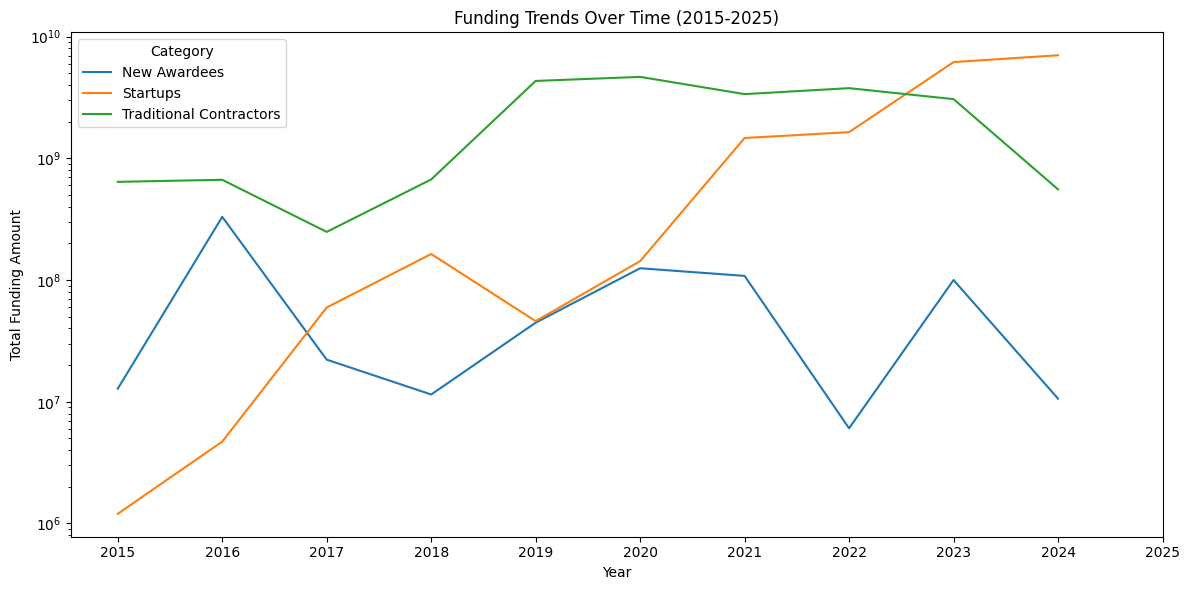

In [22]:
# aggregate data by year and category
aggregated_funding = all_funding.groupby(['year', 'category'])['amount'].sum().reset_index()

# create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=aggregated_funding, x='year', y='amount', hue='category')
plt.title('Funding Trends Over Time (2015-2025)')
plt.ylabel('Total Funding Amount')
plt.xlabel('Year')
plt.xticks(range(2015, 2026))
plt.legend(title='Category')
plt.yscale('log')  # log scale for better visualization of wide range of values
plt.tight_layout()
plt.show()

Absolutely jaw-dropping. Our line plot shows that VCs are actually investing **more** into 'space warfare' startups than government, starting in mid-2022. Can't wait to see what forecast will show!

Let's check most recent numbers:

In [23]:
funding_2024 = aggregated_funding[aggregated_funding['year'] == 2024]

# format the output
for _, row in funding_2024.iterrows():
    category = row['category']
    amount = row['amount']
    formatted_amount = f"${amount:,.2f}"
    print(f"{category}: {formatted_amount}")

# calculate total funding for 2024
total_2024 = funding_2024['amount'].sum()
formatted_total = f"${total_2024:,.2f}"
print(f"Total funding in 2024: {formatted_total}")

New Awardees: $10,608,233.23
Startups: $4,888,447,312.00
Traditional Contractors: $556,621,893.36
Total funding in 2024: $5,455,677,438.59


After creating same plots in Tableau, I noticed a serious mistake in this EDA: New Awardees (which are essentially a part of Startups) were showing the wrong funding amount, often duplicated. To mitigate this, I modified the 'amount column to reflect the proper funding and correct calculations. Thus, if company received both VC funding and government award, it will be listed twice, there will be a correct amount in each category, and not a sum of the whole funding per company in both. If New Awardee received only public funds, it will be listed only once, in NA category. 

To compare these fixed results with previous data, let's plot this again:

In [23]:
# load dataset
correct_funding = pd.read_csv('C:/Users/AM/OneDrive/Desktop/capstone/data/cleaned/all_funding_for_tableau.csv')

In [26]:
correct_funding.head()

,year,company_name,amount,state_code,category
0,2021,AALYRIA,393004,CA,New Awardees
1,2020,APOGEE SEMICONDUCTOR,124953,TX,New Awardees
2,2020,APOGEE SEMICONDUCTOR,2072337.99,TX,New Awardees
3,2019,ATLAS SPACE OPERATIONS,116251,MI,New Awardees
4,2019,ATLAS SPACE OPERATIONS,468885,MI,New Awardees


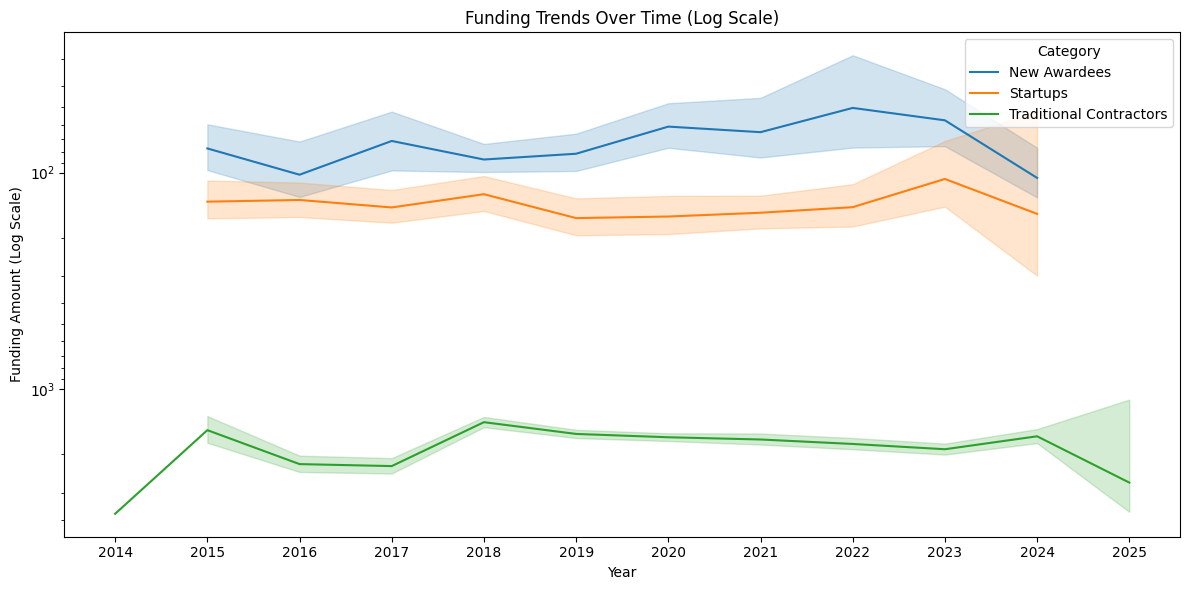

In [28]:
# create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=correct_funding, x='year', y='amount', hue='category')
plt.title('Funding Trends Over Time (Log Scale)')
plt.ylabel('Funding Amount (Log Scale)')
plt.xlabel('Year')
plt.xticks(correct_funding['year'].unique())  
plt.legend(title='Category')
plt.yscale('log')  # set y-axis to log scale
plt.tight_layout()
plt.show()

#### Key observations

**Peak funding amounts**:
- New Awardees (NA): Sharp peak in 2017
- Startups (S): Peak in 2015, 2017, 2020 (high volatility)
- Traditional Contractors (TC): peak in 2020

**Trend lines**:
- New Awardees: relatively flat with notable peaks in 2017
- Startups: fluctuating the entire time, with a big dip in 2023 and promising groeth onwards
- Traditional Contractors: starting low, peaking in 2020, then declining

**Crossover point**: Traditional Contractors overtake Startups in 2018

The space-warfare-related startup sector is showing remarkable volatility and strong competition against TCs, outpacing both new government awardees and traditional contractors before 2018. This suggests a significant shift in the industry, with private venture capital playing an increasingly important role. After 2018 it's overtaken by TCs, and decline to an all-time minimum in 2023.

Traditional contractors are seeing a decline in funding since their peak in 2020. This could indicate a shift in government strategy and effect of geopolitical events.

New government awardees show little to no change, with a single peak in 2017. This might reflect pivot of government towards innovation, but preference changes afterwards.

The fact that VC funding for startups has surpassed at one point government funding for traditional contractors is indeed remarkable. It suggests a strong private sector interest in space and defense technologies, possibly driven by technological advancements and new commercial opportunities in space. Dips caused by investor uncertainty is endangered by changing regulations and contracting priorities.

The overall trend shows a shift from traditional government-contractor relationships to a more diverse ecosystem including innovative startups. This could lead to more rapid innovation and development in the space and defense sectors.

**Pivot table**

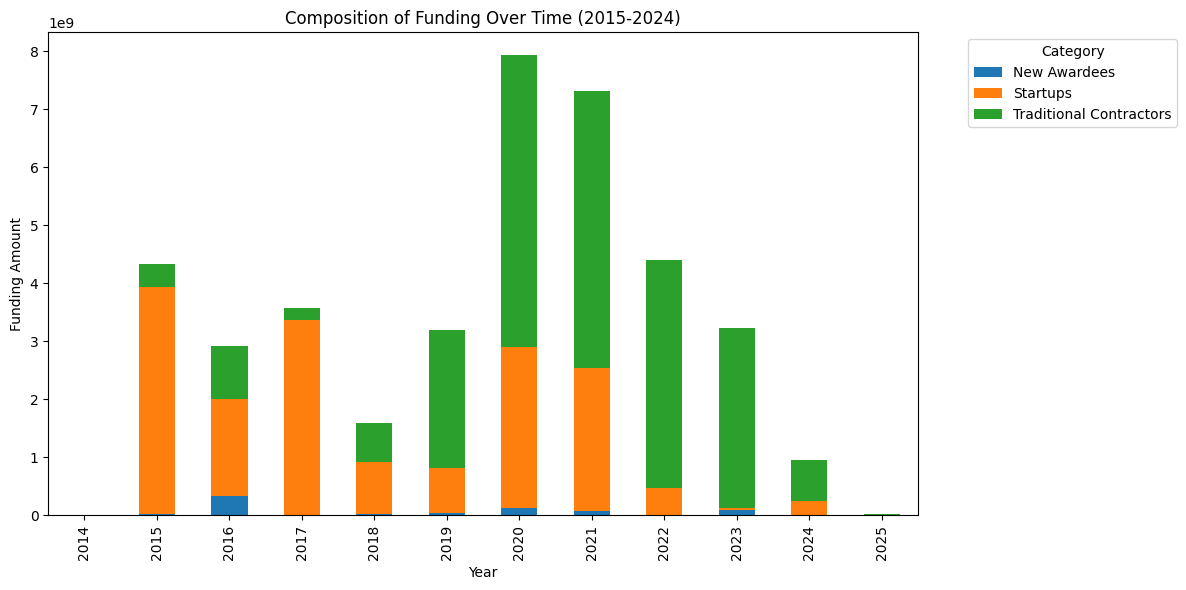

In [34]:
# pivot table showing composition of funding over time
pivot_data = correct_funding.pivot_table(values='amount', index='year', columns='category', aggfunc='sum')
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Composition of Funding Over Time (2015-2024)')
plt.ylabel('Funding Amount')
plt.xlabel('Year')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Summary statistics**

In [35]:
summary_stats = correct_funding.groupby('category').agg({
    'amount': ['sum', 'mean', 'median', 'max', 'count'],
    'company_name': 'nunique'
}).reset_index()
summary_stats.columns = ['Category', 'Total Funding', 'Average Funding', 'Median Funding', 'Max Funding', 'Number of Transactions', 'Number of Unique Companies']
print(summary_stats)

# calculate percentage of total funding
total_funding = summary_stats['Total Funding'].sum()
summary_stats['Percentage of Total Funding'] = summary_stats['Total Funding'] / total_funding * 100

print("\nPercentage of Total Funding by Category:")
print(summary_stats[['Category', 'Percentage of Total Funding']])

                  Category  Total Funding  Average Funding  Median Funding  \
0             New Awardees   7.400725e+08     3.795244e+06       225000.00   
1                 Startups   1.658288e+10     1.897354e+07            0.00   
2  Traditional Contractors   2.214850e+10     4.919703e+06       254458.86   

    Max Funding  Number of Transactions  Number of Unique Companies  
0  3.275679e+08                     195                          50  
1  1.685866e+09                     874                         874  
2  1.653362e+09                    4502                        1109  

Percentage of Total Funding by Category:
                  Category  Percentage of Total Funding
0             New Awardees                     1.874957
1                 Startups                    42.012330
2  Traditional Contractors                    56.112713


We can use the following code to create a stacked bar chart showing the number of companies funded in each category per year:

<Figure size 1200x600 with 0 Axes>

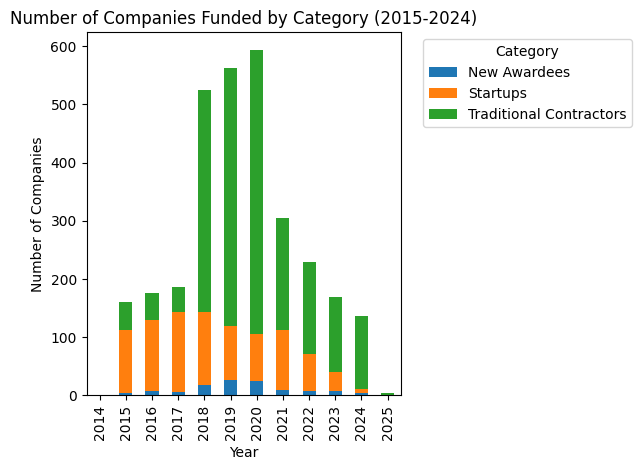

In [36]:
companies_per_year = correct_funding.groupby(['year', 'category'])['company_name'].nunique().unstack()

plt.figure(figsize=(12, 6))
companies_per_year.plot(kind='bar', stacked=True)
plt.title('Number of Companies Funded by Category (2015-2024)')
plt.ylabel('Number of Companies')
plt.xlabel('Year')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Investigating the types of technologies or services being funded in each category: for startups, we can create a word cloud of the industries

In [37]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


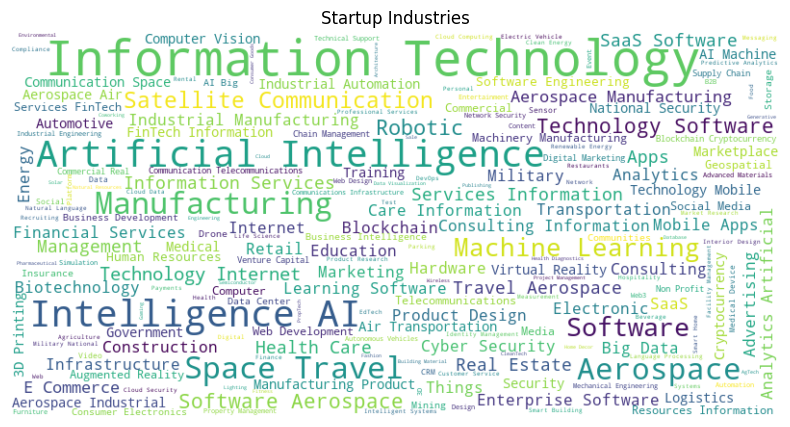

In [38]:
from wordcloud import WordCloud

startup_industries = ' '.join(crunchbase['Industries'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(startup_industries)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Startup Industries')
plt.show()

For government contracts, we can use the NAICS descriptions:

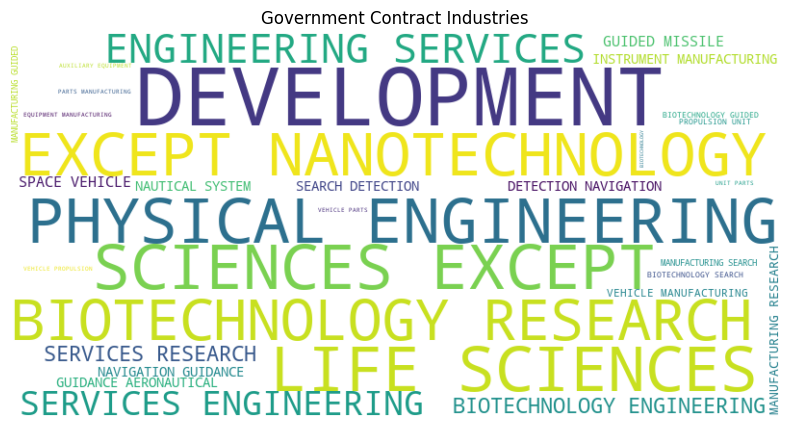

In [28]:
govt_industries = ' '.join(usa_spending['naics_description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(govt_industries)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Government Contract Industries')
plt.show()

Analyzing the geographic distribution of funding, especially for startups:

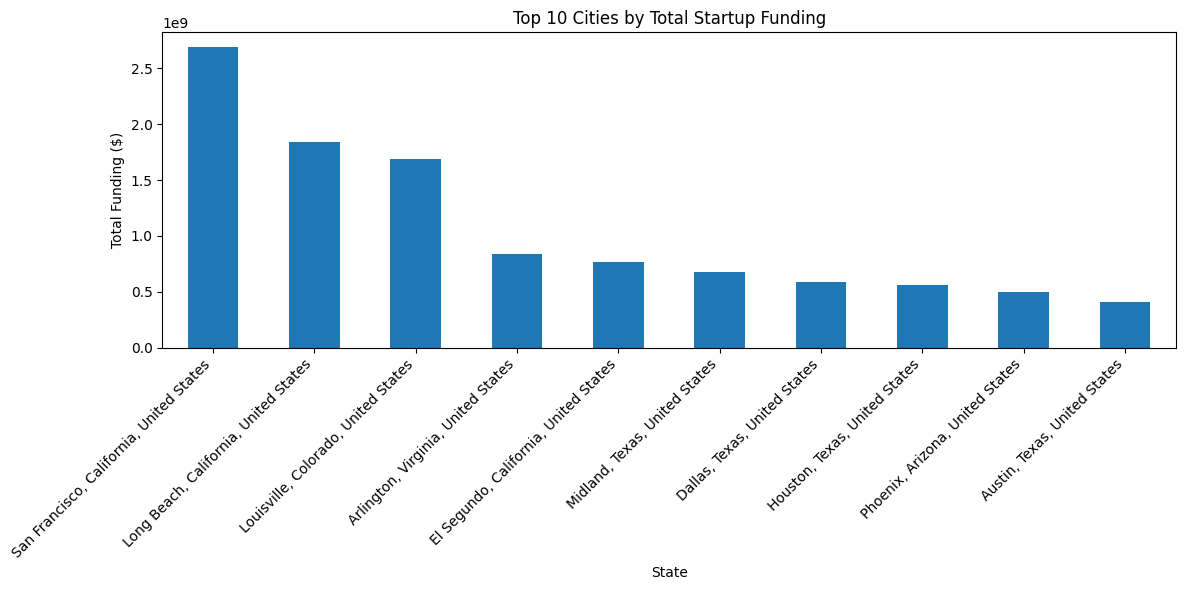

In [29]:
startup_funding_by_state = crunchbase.groupby('hq')['total_funding'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
startup_funding_by_state.plot(kind='bar')
plt.title('Top 10 Cities by Total Startup Funding')
plt.ylabel('Total Funding ($)')
plt.xlabel('State')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Exploring correlations between major world events or policy changes and the funding trends: we can create a line plot of funding trends and annotate it with major events

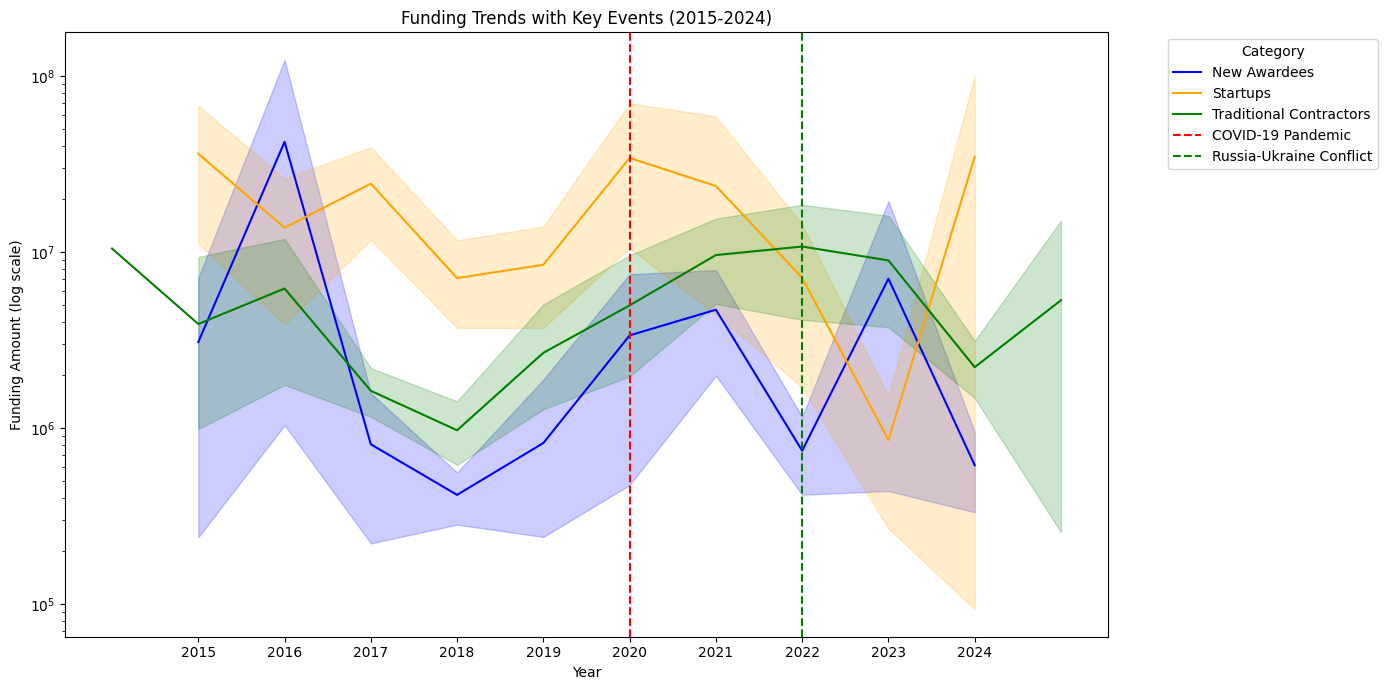

In [39]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=correct_funding, x='year', y='amount', hue='category',
             palette={'New Awardees': 'blue', 'Startups': 'orange', 'Traditional Contractors': 'green'})
plt.title('Funding Trends with Key Events (2015-2024)')
plt.ylabel('Funding Amount (log scale)')
plt.xlabel('Year')
plt.yscale('log')
plt.xticks(range(2015, 2025))

plt.axvline(x=2020, color='r', linestyle='--', label='COVID-19 Pandemic')
plt.axvline(x=2022, color='g', linestyle='--', label='Russia-Ukraine Conflict')

plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The idea of including the analysis of global events that may have correlated with defense funding trends is exciting. I decided to explore it further. This can provide a rich context for understanding what drives changes in our data.

We will add more relevant event and check for correlations:

In [31]:
import numpy as np

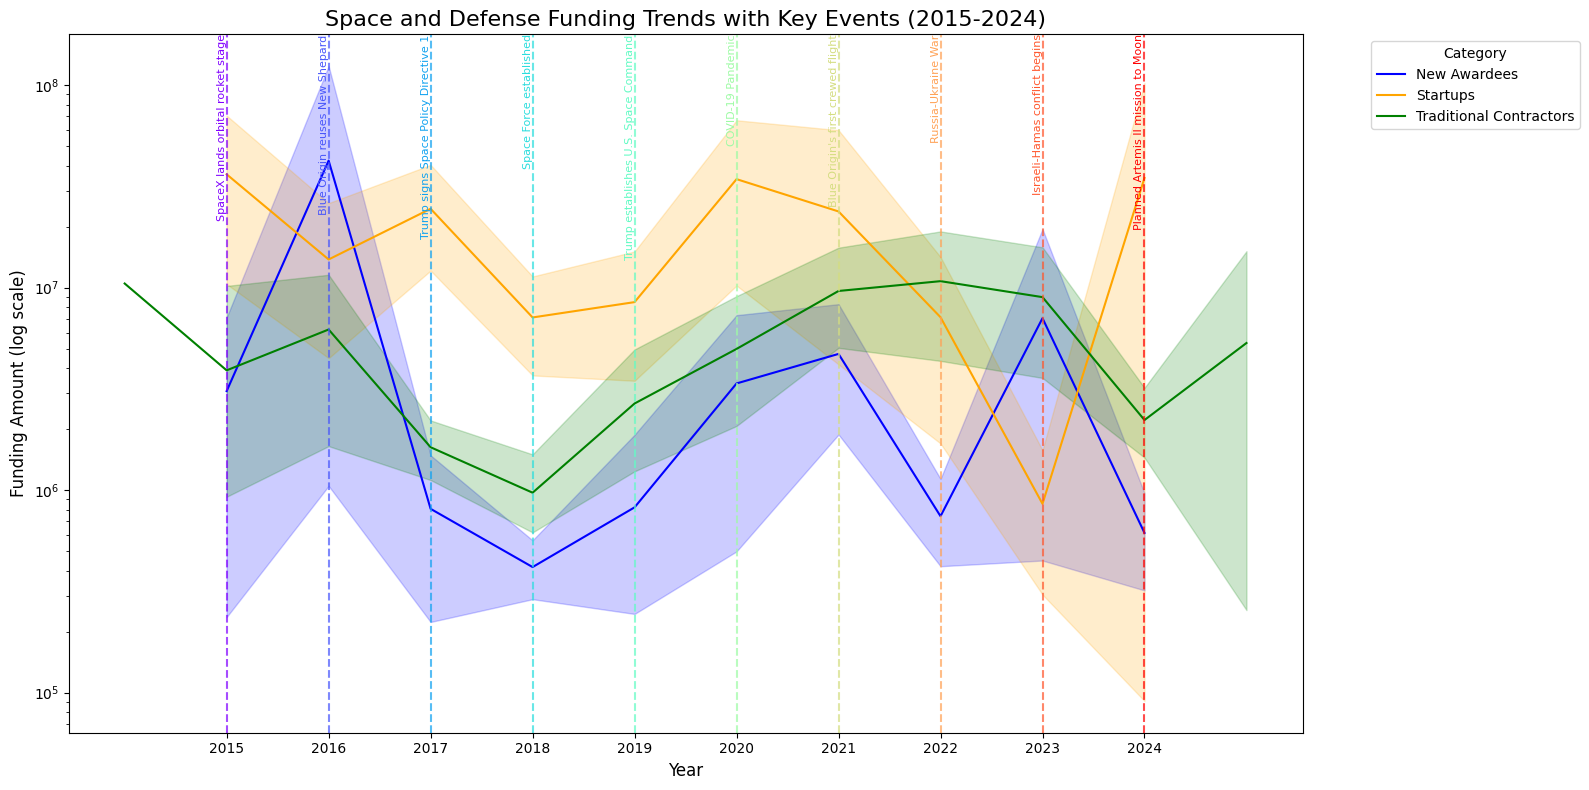

In [40]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=correct_funding, x='year', y='amount', hue='category', 
             palette={'New Awardees': 'blue', 'Startups': 'orange', 'Traditional Contractors': 'green'})
plt.title('Space and Defense Funding Trends with Key Events (2015-2024)', fontsize=16)
plt.ylabel('Funding Amount (log scale)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.yscale('log')
plt.xticks(range(2015, 2025))

events = [
    (2015, "SpaceX lands orbital rocket stage"),
    (2016, "Blue Origin reuses New Shepard"),
    (2017, "Trump signs Space Policy Directive 1"),
    (2018, "Space Force established"),
    (2019, "Trump establishes U.S. Space Command"),
    (2020, "COVID-19 Pandemic"),
    (2021, "Blue Origin's first crewed flight"),
    (2022, "Russia-Ukraine War"),
    (2023, "Israeli-Hamas conflict begins"),
    (2024, "Planned Artemis II mission to Moon")
]

colors = plt.cm.rainbow(np.linspace(0, 1, len(events)))
for (year, event), color in zip(events, colors):
    plt.axvline(x=year, color=color, linestyle='--', alpha=0.7)
    plt.text(year, plt.gca().get_ylim()[1], event, rotation=90, 
             verticalalignment='top', horizontalalignment='right', 
             fontsize=8, color=color)

plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

There are several open-source datasets that can be used to combine with our dataset and analyze the impact of big events on defense funding trends. 

One notable dataset is the [GDELT Project](https://www.gdeltproject.org/). The GDELT Project monitors the world's broadcast, print, and web news from nearly every corner of every country in over 100 languages and identifies events driving global society. It records over 300 categories of physical activities around the world, from riots and protests to peace appeals and diplomatic exchanges.

I can potentially access the GDELT dataset and use it to identify significant events that might correlate with fluctuations in defense funding trends [STRETCH ACTIVITY].

We could also use a more stable and well-documented API for global events data, such as the [ACLED](https://acleddata.com/conflict-index/) (Armed Conflict Location & Event Data Project) API.